# Import dependencies

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import time
import pandas as pd
import os
import torch
import torchtext
import logging
import matplotlib.pyplot as plt

# Processing the data.tsv file

## For proper operation, copy the file "data.tsv" into the colab directory. To navigate there, just press the "files" button on the left of the window, then press Right click--> upload, then choose the file

## Reading the file

In [4]:
tsv_file = open("data.tsv")
read_tsv = csv.reader(tsv_file, delimiter="\t")

# convert read data into an array
text_list = []
for i, row in enumerate(read_tsv):
    if(i == 0):
        continue
    else:
        text_list.append(row)
tsv_file. close()

text_array = np.array(text_list)

## Checking that there are equal number of subjective and objective examples

### "check_equal_subjective_objective" function

DESCRIPTION: checks whether the dataset has an equal number of subjective (represented with label '1')
      and objective (represented with label '0') examples

INPUT:

    input_array: array for the dataset
    
    dataset_name: name associated with the dataset
    
OUTPUT:

    subjective_counter: number of subjective examples

In [11]:
def check_equal_subjective_objective(input_array, dataset_name):
    subjective_counter = 0
    objective_counter = 0
    for i in range(input_array.shape[0]):
        if (input_array[i, 1] == '1'):
            subjective_counter += 1
        else:
            objective_counter += 1

    if (subjective_counter == objective_counter):
        print("equal number of subjective & objective examples in the " + dataset_name + " dataset")
    else:
        print("unequal number of subjective & objective examples in the " + dataset_name + " dataset")
        exit()

    return subjective_counter

### Execute the function

In [13]:
subjective_counter = check_equal_subjective_objective(text_array, "whole")

equal number of subjective & objective examples in the whole dataset


## Split data into train, validation & test sets

### "split_subjective_objective" function

  DESCRIPTION: Given the input dataset and the number of subjective examples, split
      the dataset into 2 arrays, one has only subjective examples, and the
      other has only objective examples

  INPUT:
  
    text_array: input dataset to be split

    num_subjective_examples: number of subjective examples

  OUTPUT:
    
    subjective_array: array with subjective-only examples
    
    objective_array: array with objective-only examples

In [14]:
def split_subjective_objective(text_array, num_subjective_examples):
    # create empty arrays for each label type
    # second dimension with shape 2: 1st dimension is input, 2nd is label
    subjective_array = np.empty((num_subjective_examples, 2), dtype=object)
    objective_array = np.empty((num_subjective_examples, 2), dtype=object)

    subjective_counter = 0
    objective_counter = 0
    for i in range(text_array.shape[0]):
        # label '1' is subjective, label '0' is objective
        if (text_array[i, 1] == '1'):
            subjective_array[subjective_counter, :] = text_array[i, :]
            subjective_counter += 1
        else:
            objective_array[objective_counter, :] = text_array[i, :]
            objective_counter += 1

    return subjective_array, objective_array

### "create_dataset" function

DESCRIPTION:
    given subjective and objective arrays, extract subarrays from each and
    combine these subarrays into one array. The subarrays are extracted according
    to their start and end indices

INPUT:

    subjective_array: array with subjective-only examples
    
    objective_array: array with objective-only examples
    
    start_index: start index for the subarrays
    
    end_index: end index for the subarrays

OUTPUT:

    dataset: array which consists of the subarrays from the subjetive and
    
    objective arrays. This output array is shuffled.


In [16]:
def create_dataset(subjective_array, objective_array, start_index, end_index):
  subjective_set = subjective_array[start_index : end_index, ...]
  objective_set = objective_array[start_index : end_index, ...]
  dataset = np.concatenate((subjective_set, objective_set), axis=0)
  # shuffling the dataset
  np.random.seed(0)
  np.random.shuffle(dataset)

  return dataset

### "check_uniqueness_sample" function


DESCRIPTION:
      Given the whole dataset and each of the training, validation, and test
      sets, check that each example in the whole dataset is found in only
      one of the 3 sets (unique to that set).
      
INPUT:

      text_array: whole dataset
      
      training_set: training dataset
      
      validation_set: validation dataset
      
      test_set: test dataset

OUTPUT:
      
      None


In [17]:
def check_uniqueness_sample(text_array, training_set, validation_set, test_set):

    # convert array of input examples to list
    training_list = training_set[:, 0].tolist()
    validation_list = validation_set[:, 0].tolist()
    test_list = test_set[:, 0].tolist()

    # counter for the number of occurences of an example in the 3 sets
    detection_counter = 0

    # in case an example is found in more than one set, check the rest of the
    # examples before terminating the code
    exit_later = False

    for i in range(text_array.shape[0]):
        if (text_array[i, 0] in training_list):
            detection_counter += 1
        if (text_array[i, 0] in validation_list):
            detection_counter += 1
        if (text_array[i, 0] in test_list):
            detection_counter += 1

        # detect whether an example is duplicated
        if (detection_counter > 1):
            print(f"example {i} is repeated in more than one dataset")
            exit_later = True
        # detect whether an example is not included in any of the 3 sets
        elif (detection_counter == 0):
            print(f"example {i} is not found in any dataset")
            exit_later = True

        detection_counter = 0

    if (exit_later):
        exit()

    print("training, validation, and test datasets all include unique examples")

    return

#### Split the dataset into the training, validation, and test sets by executing the 4 functions "split_subjective_objective", "create_dataset", "check_equal_subjective_objective", "check_uniqueness_sample"

##### split data into subjective and objective arrays

In [18]:
num_subjective_examples = subjective_counter
subjective_array, objective_array = split_subjective_objective(text_array, num_subjective_examples)

##### calculate the size of the training and validation sets (this is to get the start and end indices of their arrays for splitting the whole array ahead). Start and end indices can be deduced from these calculated values

In [21]:
# shuffle each array so that they don't have the same order as the data.tsv file
np.random.seed(0)
np.random.shuffle(subjective_array)
np.random.shuffle(objective_array)

# training set is 64% of the total, validation is 16% and test set is the
# remaining 20%
train_examples_size = int(0.64 * num_subjective_examples) # size of training set
validation_examples_size = int(0.16 * num_subjective_examples)  # size of validation set

##### split the whole dataset into training, validation, and test sets

In [24]:
# to make sure there is no overlap, the end index for one set must be the start
# index for the next set
train_set = create_dataset(subjective_array, objective_array, 0, train_examples_size)
validation_set = create_dataset(subjective_array, objective_array, train_examples_size,
                                (train_examples_size + validation_examples_size))
test_set = create_dataset(subjective_array, objective_array, (train_examples_size + validation_examples_size),
                          num_subjective_examples)

##### verify that there are equal number of subjective and objective examples in each dataset and then check that every example is unique to only one dataset

In [25]:
# verification checks
check_equal_subjective_objective(train_set, "training set")
check_equal_subjective_objective(validation_set, "validation set")
check_equal_subjective_objective(test_set, "test set")
check_uniqueness_sample(text_array, train_set, validation_set, test_set)

equal number of subjective & objective examples in the training set dataset
equal number of subjective & objective examples in the validation set dataset
equal number of subjective & objective examples in the test set dataset
training, validation, and test datasets all include unique examples


## saving each dataset into a .tsv file

### convert each array to a pandas dataframe

In [26]:
# convert arrays to pandas dataframes
dataframe_col_names = ["text", "label"]
train_dataframe = pd.DataFrame(train_set, columns = dataframe_col_names)
validation_dataframe = pd.DataFrame(validation_set, columns = dataframe_col_names)
test_dataframe = pd.DataFrame(test_set, columns = dataframe_col_names)

### save each pandas dataframe as a .tsv file

In [29]:
# store the datasets in .tsv files
# path should be "./data/{dataset_name}.tsv"
train_dataframe.to_csv("train.tsv", index = None, sep="\t")
validation_dataframe.to_csv("validation.tsv", index = None, sep="\t")
test_dataframe.to_csv("test.tsv", index = None, sep="\t")

## Final text processing and converting examples into torch tensors

### "TextDataset" class

#### the following class converts the input dataset torch tensors convert every word in the inputs to its corresponding token according to the used embedding matrix (GloVe in our case), & any word that is not represented in the embedding matrix gets an "out-of-vocabulary" token

In [31]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(f"{split}.tsv", sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            # split input sentence into a list of its words
            L = row["text"].split()
            # convert each word in the sentence with its corresponding token
            # and convert the output vector into a torch tensor
            X.append(torch.tensor([vocab.stoi.get(w, V - 1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)    # convert labels into a torch tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

### "my_collate_function" function

DESCRIPTION: this function prepares batches for being used with the model. batch is approximately: [dataset[i] for i in range(0, batch_size)]. Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function should be set correspondingly. Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), we need to wrap up an anonymous function (using lambda, as will be shown when executing this function). Padding for the text is handled here as well.

In [32]:
def my_collate_function(batch, device):
    batch_x, batch_y = [], []
    max_len = 0
    for x, y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x, y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

# Create and train the MLP (Single Neuron) classifier model

## "Classifier model" class

### this class describes the architecture of the classifier model used in this notebook. We declare the layers used in the model in the __init__ function, then we outline how these layers are organized/stacked in the forward function

In [33]:
class ClassifierModel(torch.nn.Module):
    def __init__(self, vocab_vectors):
        super().__init__()

        self.embedding_size = vocab_vectors.shape[1]

        self.embedding = torch.nn.Embedding.from_pretrained(vocab_vectors) # embedding layer
        self.linear_NN = torch.nn.Linear(self.embedding_size, 1) # fully connected layer

    def forward(self, x):
        """
        x: torch.tensor of shape (bsz, sentence_max_len)
        """
        # TO DO
        bsz = int(x.shape[0])
        max_len = int(x.shape[1])

        input_embedding_matrix = self.embedding(x) # shape : (max_len, embedding_size)
        averaged_embedding = torch.mean(input_embedding_matrix, dim = 1) # shape : (embedding_size)
        linear_output = self.linear_NN(averaged_embedding)

        return linear_output, input_embedding_matrix

## Functions that are used for model training

### "prediction_accuracy" function

DESCRIPTION:
      this function takes the linear output of the NN and applies the sigmoid
      and the decision function, then it computes the accuracy

INPUTS:

      predicted: predicted values from the model for a certain batch
      
      ground_truth: ground-truth values for each batch
      
      sigmoid_fn: sigmoid activation function
      
OUTPUTS:

      average_accuracy_per_batch: average accuracy per batch

In [34]:
# the prediction_accuracy function is defined first as it is used in the fit function
def prediction_accuracy(predicted, ground_truth, sigmoid_fn):
    bsz = ground_truth.shape[0]   # batch size

    sigmoid_output = sigmoid_fn(predicted)

    # count the number of correct predictions
    accuracy_counter = 0
    for i in range(bsz):
        if (sigmoid_output[i] == 0.5):    # if it's neither subjective or objective, then it's still a misclassification
            continue
        elif (sigmoid_output[i] > 0.5 and ground_truth[i] == 1):
            accuracy_counter += 1
        elif (sigmoid_output[i] < 0.5 and ground_truth[i] == 0):
            accuracy_counter += 1

    average_accuracy_per_batch = accuracy_counter / bsz

    return average_accuracy_per_batch

### "Batch_iteration" function

DESCRIPTION: get outputs of the model for a single batch of training/validation/test data. Also, the function calculates the batch loss and accuracy and adds that to the loss and accuracy of the whole epoch

INPUTS:

    batch: batch that is input to the model

    batch_size: size of the batch used

    optimizer: optimzer used for training
    
    loss_fn: loss function used for training
    
    running_loss: running loss for the epoch
    
    running_accuracy: running accuracy for the epoch
    
    NN_model: classifier model
    
    training_batch = False: flag to determine whether this is a training batch or validation/test batch

OUTPUTS:

    running_loss: running loss for the epoch after adding the batch's loss
    
    running_accuracy: running accuracy for the epoch after adding the batch's accuracy

In [35]:
def Batch_iteration(batch, batch_size, running_loss, running_accuracy, NN_model,
                    prediction_sigmoid_fn, training_batch = False, optimizer = None, loss_fn = None):
    inputs = batch[0]   # input examples of the batch
    labels = batch[1]   # ground-truth values for each input in the batch

    # check whether the "inputs" vector should be transposed to be used correctly
    if (inputs.shape[0] != batch_size):
        assert inputs.shape[1] == batch_size, "shape of input is inconsistent with batch size"
        inputs = torch.transpose(inputs, 0, 1)

    if training_batch:
        # Zero your gradients for every batch!
        optimizer.zero_grad()

    # Make predictions for this batch
    predicted_outputs, input_embeddings = NN_model.forward(inputs)

    # make sure that labels and predicted_outputs will have matching types and shapes
    if (len(predicted_outputs.shape) > 1):
        predicted_outputs = torch.squeeze(predicted_outputs)
    if (labels.dtype != torch.float32):
        labels = labels.float()

    # Compute the loss
    if loss_fn is not None:
      loss = loss_fn(predicted_outputs, labels)
    else:
      loss = 0

    # compute gradients for the loss
    if training_batch:
        loss.backward()

    running_loss += loss

    # get training accuracy
    accuracy = prediction_accuracy(predicted_outputs, labels, prediction_sigmoid_fn)
    running_accuracy += accuracy

    if training_batch:
        # Adjust learning weights
        optimizer.step()

    return running_loss, running_accuracy

### "plot_2curves" function

DESCRIPTION: plot 2 curves on the same figure

INPUTS:

    x: array of inputs for each curve (should be the same for the 2 curves)
  
    y1: array of outputs for the first curve
  
    y2: array of outputs for the second curve
  
    y1_label: label for the first curve
  
    y2_label: label for the second curve
  
    plot_title: title of the figure

OUTPUTS:

    None

In [37]:
def plot_2curves(x, y1, y2, y1_label, y2_label, plot_title):
  plt.figure()
  plt.plot(x, y1, color="b", label=y1_label)
  plt.plot(x, y2, color="r", label=y2_label)
  plt.title(plot_title)
  plt.legend()
  plt.show(block = False)

  return

### "model_fit" function

DESCRPTION:
      fit the given model to the given training set, and check whether it's
      generalizing well to the validation set. After training is completed, test
      the final performance of the model on the test set

INPUT:

      NN_model: model that will be trained

      train_dataloader: object that stores batches of the training set

      validation_dataloader: object that stores batches of the validation set

      test_dataloader: object that stores batches of the test set

      batch_size = 4: batch size used (default value is 4)

      learning_rate = 0.001: learning rate used for optimization (default value is 0.001)

      EPOCHS = 50: number of passes through the whole training set (default value is 50)

      l2 = 0: L2 regularization parameter (default value is 0)

OUTPUT:

      None

In [38]:
def model_fit(NN_model, train_dataloader,validation_dataloader, test_dataloader,
                  batch_size = 4, learning_rate = 0.001, EPOCHS = 50, l2 = 0):

    np.random.seed(2)
    torch.manual_seed(2)

    # loss function
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.Adam(NN_model.parameters(), lr=learning_rate, weight_decay=l2)

    # number of batches for each dataset
    training_batches = len(train_dataloader)
    validation_batches = len(validation_dataloader)
    test_batches = len(test_dataloader)

    # arrays for tracking the loss values for training and validation sets for every epoch
    training_loss_per_epoch = np.zeros(EPOCHS)
    validation_loss_per_epoch = np.zeros(EPOCHS)

    # arrays for tracking the accuracies for training and validation sets for every epoch
    training_accuracy_per_epoch = np.zeros(EPOCHS)
    validation_accuracy_per_epoch = np.zeros(EPOCHS)

    prediction_sigmoid_fn = torch.nn.Sigmoid() # used for getting prediction accuracy

    # training loop
    for epoch in range(EPOCHS):
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        for batch in train_dataloader:
            running_train_loss, running_train_accuracy = \
            Batch_iteration(batch, batch_size, running_train_loss, running_train_accuracy, NN_model, \
                            prediction_sigmoid_fn, training_batch = True, optimizer=optimizer, loss_fn=loss_fn)

        # average training loss for this epoch
        avg_train_loss = running_train_loss / training_batches
        training_loss_per_epoch[epoch] = avg_train_loss

        # average training accuracy for this epoch
        avg_train_accuracy = running_train_accuracy / training_batches
        training_accuracy_per_epoch[epoch] = avg_train_accuracy

        running_validation_loss = 0.0
        running_validation_accuracy = 0.0

        # validation loop
        for batch in validation_dataloader:
          running_validation_loss, running_validation_accuracy = \
          Batch_iteration(batch, batch_size, running_validation_loss, running_validation_accuracy, \
                          NN_model, prediction_sigmoid_fn, training_batch = False, optimizer=optimizer, loss_fn=loss_fn)

        # average validation loss for this epoch
        avg_validation_loss = running_validation_loss / validation_batches
        validation_loss_per_epoch[epoch] = avg_validation_loss

        # average validation accuracy for this epoch
        avg_validation_accuracy = running_validation_accuracy / validation_batches
        validation_accuracy_per_epoch[epoch] = avg_validation_accuracy

        print(f'EPOCH: {epoch} \t LOSS train {avg_train_loss:.3f}, \t valid {avg_validation_loss:.3f}, '
              f'ACC train {avg_train_accuracy:.3f}, \t valid {avg_validation_accuracy:.3f}')

    # plot training and validation losses across the epochs
    plot_2curves(np.arange(EPOCHS), training_loss_per_epoch, \
                 validation_loss_per_epoch, "train loss", "validation loss", "Training & validation losses")

    # plot training and validation accuracies across the epochs
    plot_2curves(np.arange(EPOCHS), training_accuracy_per_epoch, \
                 validation_accuracy_per_epoch, "train accuracy", "validation accuracy", "Training & validation accuracies")

    # plot training loss and accuracy across the epochs
    plot_2curves(np.arange(EPOCHS), training_loss_per_epoch, \
                 training_accuracy_per_epoch, "train loss", "train accuracy", "Training loss & accuracy")

    # test loop
    running_test_accuracy = 0.0
    running_test_loss = 0.0   # we don't actually care about this loss, we're just declaring it for the  Batch_iteration function
    for batch in test_dataloader:
      _, running_test_accuracy = \
      Batch_iteration(batch, batch_size, running_test_loss, running_test_accuracy, NN_model, \
                            prediction_sigmoid_fn, training_batch = False)

    avg_test_accuracy = running_test_accuracy / test_batches

    print(f'Test accuracy is {avg_test_accuracy:.3f}')

    return

## "model_test" function

DESCRIPTION:
      test the trained model on the test set

INPUTS:

      NN_model: classifier model

      test_dataloader: objects that stores batches of the test set

      batch_size = 4: size of the batch that's fed to the model (default value is 4)

OUTPUTS:

      None

In [39]:
def model_test(NN_model, test_dataloader, batch_size = 4):
    np.random.seed(2)
    torch.manual_seed(2)

    test_batches = len(test_dataloader)

    prediction_sigmoid_fn = torch.nn.Sigmoid() # used for getting prediction accuracy

    # test loop
    running_test_accuracy = 0.0
    running_test_loss = 0.0 # we don't actually care about this loss, we're just declaring it for the  Batch_iteration function
    for batch in test_dataloader:
        _, running_test_accuracy = \
      Batch_iteration(batch, batch_size, running_test_loss, running_test_accuracy, NN_model, \
                            prediction_sigmoid_fn)

    avg_test_accuracy = running_test_accuracy / test_batches

    print(f'Test accuracy is {avg_test_accuracy:.3f}')

    return

# Actual training of the model

## load the glove embedding matrix

In [40]:
# load the glove embedding matrix for use in the model

# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
glove = torchtext.vocab.GloVe(name="6B", dim=100)  # embedding size = 100

.vector_cache/glove.6B.zip: 862MB [02:40, 5.39MB/s]                           
100%|█████████▉| 399999/400000 [00:48<00:00, 8276.18it/s]


## set the hyperparameters, and choose the processor used for training

In [41]:
# hyperparameters for model training
batch_size = 4
learning_rate = 0.001
l2 = 0
EPOCHS=10

#   fix seed
torch.manual_seed(2)

# use GPU if possible, if not, then CPU is automatically used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


## define the dataloader for the training, validation, and test sets

In [42]:
# convert each dataset into its equivalent torch tensor
train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")

# objects that handle batching of torch tensors
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device), drop_last = True)

validation_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device), drop_last = True)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device), drop_last = True)

## instantiate the model and execute the fit function. Save the model after training

EPOCH: 0 	 LOSS train 0.610, 	 valid 0.537, ACC train 0.760, 	 valid 0.847
EPOCH: 1 	 LOSS train 0.493, 	 valid 0.460, ACC train 0.850, 	 valid 0.858
EPOCH: 2 	 LOSS train 0.433, 	 valid 0.417, ACC train 0.861, 	 valid 0.864
EPOCH: 3 	 LOSS train 0.398, 	 valid 0.391, ACC train 0.864, 	 valid 0.864
EPOCH: 4 	 LOSS train 0.375, 	 valid 0.373, ACC train 0.868, 	 valid 0.867
EPOCH: 5 	 LOSS train 0.359, 	 valid 0.360, ACC train 0.871, 	 valid 0.868
EPOCH: 6 	 LOSS train 0.347, 	 valid 0.350, ACC train 0.874, 	 valid 0.872
EPOCH: 7 	 LOSS train 0.338, 	 valid 0.342, ACC train 0.876, 	 valid 0.874
EPOCH: 8 	 LOSS train 0.330, 	 valid 0.335, ACC train 0.877, 	 valid 0.876
EPOCH: 9 	 LOSS train 0.324, 	 valid 0.330, ACC train 0.880, 	 valid 0.877


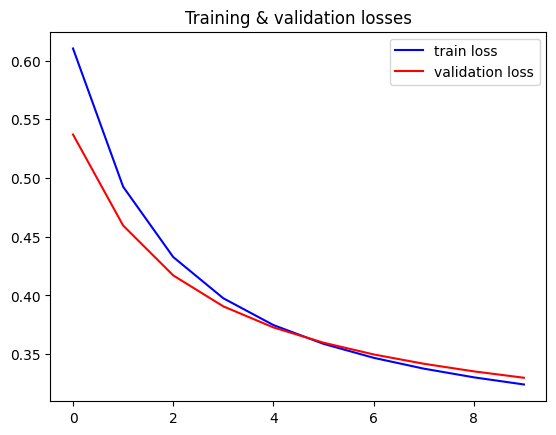

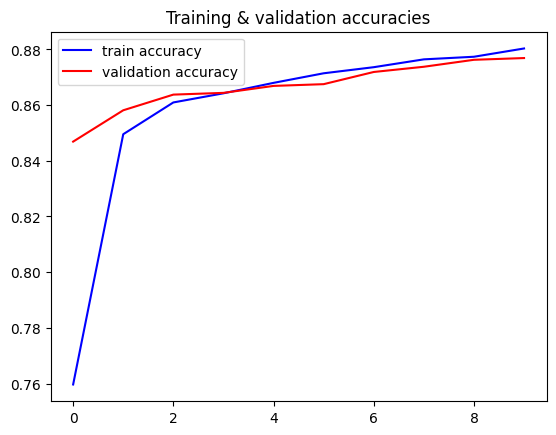

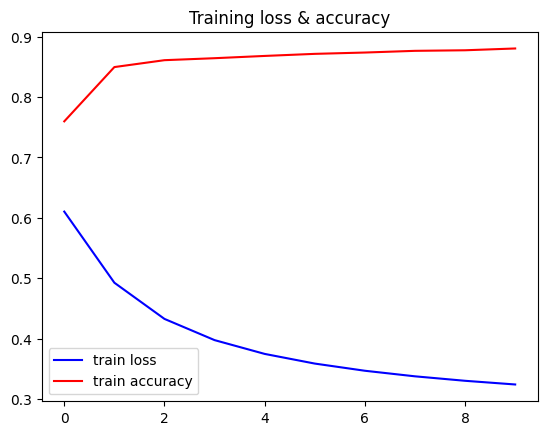

Test accuracy is 0.882
training time: 0.52 min


In [43]:
# instantiate model
Classifier_NN = ClassifierModel(glove.vectors)

start_time = time.time()
# call the model fit function to train it
model_fit(Classifier_NN, train_dataloader, validation_dataloader, test_dataloader,
              batch_size= batch_size, learning_rate= learning_rate, EPOCHS= EPOCHS,l2= l2)
training_time = time.time() - start_time
print(f"training time: {training_time/60 :.2f} min")

# save model parameters
torch.save(Classifier_NN.state_dict(), 'classifier_model.pt') # save model

# Interesting experiment

Since the model has a single neuron with its weight vector having the same size of the embedding vectors, why don't we assume that this weight vector is itself an embedding and check which words are closest to it

In [44]:
def print_closest_cosine_words(glove, vec, n=5):
    dists = torch.cosine_similarity(glove.vectors, vec.unsqueeze(0), dim=1)     # compute distances to all words
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1], reverse=True) # sort by distance
    for idx, difference in lst[1:n+1]:                         # take the top n
         print(glove.itos[idx], "\t%5.2f" % difference)

In [45]:
final_layer_weights = Classifier_NN.linear_NN.weight.data
final_layer_weights = torch.squeeze(final_layer_weights)

print_closest_cosine_words(glove, final_layer_weights, n = 20)

pleasing 	 0.57
simplistic 	 0.56
insipid 	 0.55
watchable 	 0.55
engrossing 	 0.53
flattering 	 0.53
verisimilitude 	 0.52
laughable 	 0.52
disquieting 	 0.52
realistic 	 0.52
cartoony 	 0.52
underwhelming 	 0.51
encapsulates 	 0.51
cartoonish 	 0.51
informative 	 0.51
verbiage 	 0.51
portentous 	 0.51
nuanced 	 0.51
hodgepodge 	 0.51
campy 	 0.51


# Gradio App

## install gradio and import it

In [46]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [47]:
import gradio as gr

## Sentence classification functions

### "tokenize_sentence" function

DESCRIPTION:
      convert input sentence into its corresponding tokens vector
      
INPUTS:

      input_sentence: sentence to be tokenized

OUTPUTS:

      token_tensor: tokenized vector

In [48]:
def tokenize_sentence(input_sentence):
    tokens = input_sentence.split()
    # Convert to integer representation per token
    token_ints = [glove.stoi.get(tok, len(glove.stoi) - 1) for tok in tokens]
    # Convert into a tensor of the shape accepted by the models
    token_tensor = torch.LongTensor(token_ints).view(-1, 1)

    return token_tensor

### "classify_sentence" function

  DESCRIPTION:
      using the given model and tokenized sentence, classify whether this
      sentence is subjective or objective

  INPUTS:

      NN_model: model used for classification

      tokenized_sentence: sentence to be classified after being tokenized

  OUTPUTS:

      classification: classification, whether subjective or objective

      subjectivity_probability: probability/confidence that model thinks the sentence is subjective

In [49]:
def classify_sentence(NN_model, tokenized_sentence):
    # make sure that batch size is 1
    if (tokenized_sentence.shape[0] != 1):
        assert tokenized_sentence.shape[1] == 1
        tokenized_sentence_updated = torch.transpose(tokenized_sentence, 0, 1)
    else:
        tokenized_sentence_updated = tokenized_sentence

    linear_output, *_ = NN_model(tokenized_sentence_updated)
    sigmoid_fn = torch.nn.Sigmoid()
    sigmoid_output = sigmoid_fn(linear_output)

    # We assume here that if the output of the sigmoid is 0.5, then it's classified as 0 (objective)
    if (sigmoid_output > 0.5):
        classification = "subjective"
    else:
        classification = "objective"

    subjectivity_probability = round(sigmoid_output.item(), 2)

    return classification, subjectivity_probability


## Load classifier model

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

glove = torchtext.vocab.GloVe(name="6B", dim=100)  # embedding size = 100

# load the saved model for use with Gradio
classifier_model = ClassifierModel(glove.vectors)
classifier_model.load_state_dict(torch.load('classifier_model.pt'))

Using device: cpu


<All keys matched successfully>

## set up and run gradio application

### "gradio_classifier" function

DESCRIPTION:
      this function is called when a a certain gradio button is pressed. it
      returns the model classification of the input sentence along with the
      probability of the sentence being subjective.

INPUTS:

      input_sentence: the sentence written in the gradio text box to be classified for subjectivity/objectivity

OUTPUTS:

      model_classification: classification of our used model

      model_prob: probability/confidence that model thinks the sentence is subjective

In [51]:
def gradio_classifier(input_sentence):
    tokenized_sentence = tokenize_sentence(input_sentence)
    sentence_len = tokenized_sentence.shape[0]

    model_classification, model_prob = classify_sentence(classifier_model, tokenized_sentence)

    return model_classification, model_prob

### run the Gradio app

In [52]:
with gr.Blocks() as demo:
    input_sentence = gr.Textbox(label="Sentence")
    model_class_output = gr.Textbox(label="Model classification")
    model_prob = gr.Textbox(label="Model subjectivity probability")

    classify_button = gr.Button("Classify")
    classify_button.click(fn=gradio_classifier, inputs=input_sentence,
                          outputs= [model_class_output, model_prob])

demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>